# Part 1

In this part, we will examine the daily demand for Ultimate Technologies' services. The data is in the `logins.json` file; we want to split it into 15-minutes intervals, then visualize the demand, then look for and describe patterns in the demand cycle.

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.api as sm
import json
import datetime as dt

### Bring in Data

In [2]:
with open('logins.json', 'r') as file:
    data = json.load(file)

In [3]:
data.keys()

dict_keys(['login_time'])

In [4]:
data['login_time'][0:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

The data is literally just a bunch of login datetimes. We just need to aggregate these into 15-minute intervals (by count) and then we cna plot it and analyze it, etc. Let's convert to a Pandas DataFrame and then see how many login times there are.

In [5]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [6]:
df['login_time'] = pd.to_datetime(df['login_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Now that they are datetimes, let's make sure they are in the right order.

In [7]:
df = df.sort_values('login_time').reset_index(drop=True)
df.head()

login_time
0 1970-01-01 20:12:16
1 1970-01-01 20:13:18
2 1970-01-01 20:16:10
3 1970-01-01 20:16:36
4 1970-01-01 20:16:37

In [8]:
df.tail()

login_time
93137 1970-04-13 18:48:52
93138 1970-04-13 18:50:19
93139 1970-04-13 18:54:02
93140 1970-04-13 18:54:23
93141 1970-04-13 18:57:38

In [9]:
df.iloc[-1,0] - df.iloc[0,0]

Timedelta('101 days 22:45:22')

There are 93,142 observations over the course of about 102 days. I am assuming the dates are not correct, but that the passage of time is correct (unlikely that people were logging on in 1970, eh?).

### Aggregate into 15 minute Intervals

In [10]:
df['demand'] = [1]*df.shape[0]
df_int = df.groupby([pd.Grouper(key='login_time', freq='15min')]).agg({'demand':'count'})

In [11]:
df_int.head()

demand
login_time                 
1970-01-01 20:00:00       2
1970-01-01 20:15:00       6
1970-01-01 20:30:00       9
1970-01-01 20:45:00       7
1970-01-01 21:00:00       1

### Visualize Demand

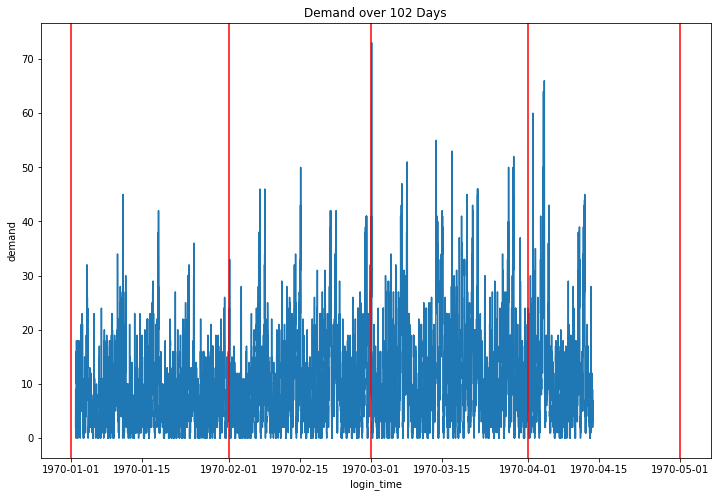

In [12]:
plt.figure(figsize=(12,8))
sns.lineplot(x=df_int.index, y='demand', data=df_int)
plt.title('Demand over 102 Days')
months = [dt.datetime.strptime('1970-01-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-02-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-03-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-04-01', '%Y-%m-%d'),
          dt.datetime.strptime('1970-05-01', '%Y-%m-%d')]
for month in months:
    plt.axvline(month, c='red');

A quick glance seems to show a weekly pattern. Let's examine the data on a monthly basis to get a closer look.

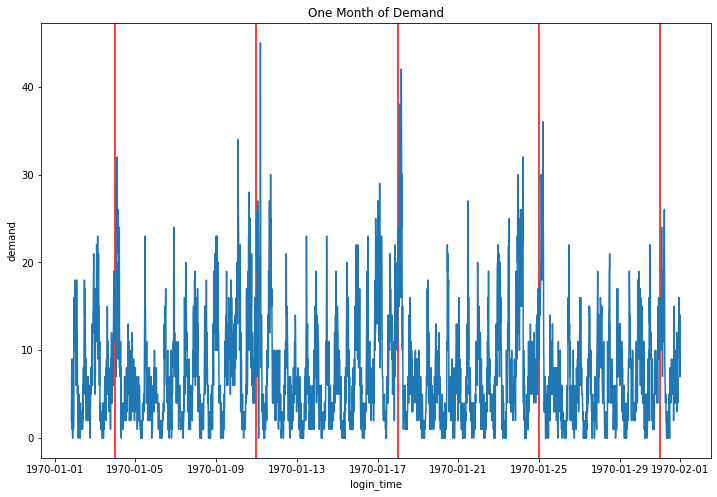

In [13]:
plt.figure(figsize=(12,8))
month = df_int.loc['1970-01']
plt.title('One Month of Demand')
plt.axvline(x=dt.datetime.strptime('1970-01-04', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-11', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-18', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-25', '%Y-%m-%d'), c='red')
plt.axvline(x=dt.datetime.strptime('1970-01-31', '%Y-%m-%d'), c='red')

sns.lineplot(x=month.index, y='demand', data=month);

There does appear to be a weekly seasonal component. Let's look closer at a single week.

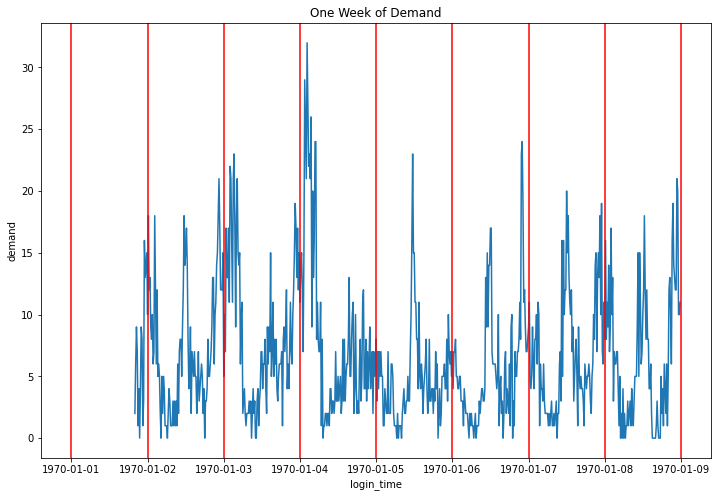

In [14]:
plt.figure(figsize=(12,8))
week = df_int.loc['1970-01-01':'1970-01-8']
plt.title('One Week of Demand')
day_markers = [dt.datetime.strptime(''.join(['1970-01-0', str(i)]), '%Y-%m-%d') for i in range(1,10)]
sns.lineplot(x=week.index, y='demand', data=week)
for day in day_markers:
    plt.axvline(x=day, c='red');

It looks like the seasonality might actually be on a 12-hour cycle!

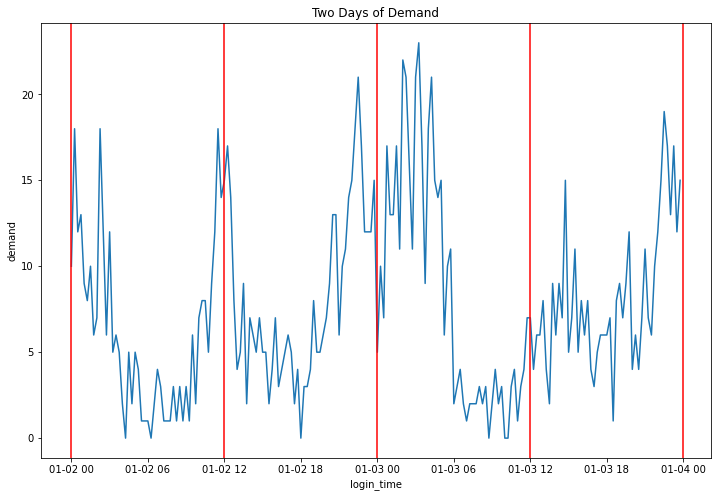

In [15]:
plt.figure(figsize=(12,8))
days = df_int.loc['1970-01-02':'1970-01-03']
plt.title('Two Days of Demand')
sns.lineplot(x=days.index, y='demand', data=days)
hourly_cycle = [dt.datetime.strptime('1970-01-02', '%Y-%m-%d')]
for cycle in range(5):
    hourly_cycle.append(hourly_cycle[cycle] + dt.timedelta(hours=12))
    plt.axvline(x=hourly_cycle[cycle], c='red');

Yes, that certainly appears to have an approximately 12-hour cycle.

In [16]:
df_int.loc['1970-01']

demand
login_time                 
1970-01-01 20:00:00       2
1970-01-01 20:15:00       6
1970-01-01 20:30:00       9
1970-01-01 20:45:00       7
1970-01-01 21:00:00       1
...                     ...
1970-01-31 22:45:00      16
1970-01-31 23:00:00      10
1970-01-31 23:15:00       9
1970-01-31 23:30:00       7
1970-01-31 23:45:00      14

[2896 rows x 1 columns]

## Look for Broader Patterns

We are going to aggregate the login counts by different frequencies to look for patterns too broad to see clearly at 15-minute intervals.

### Aggregate BiWeekly

In [17]:
df_biweekly = df.groupby([pd.Grouper(key='login_time', freq='2w')]).agg({'demand':'sum'})

In [18]:
X = range(len(df_biweekly.index))
y = df_biweekly['demand']
X = sm.add_constant(X)
biweekly_trendmodel = sm.OLS(y,X).fit()

In [19]:
line_y = biweekly_trendmodel.predict(X)

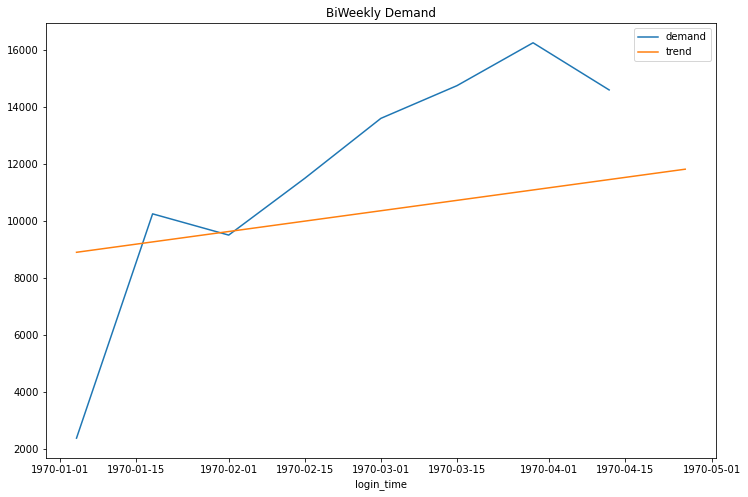

In [20]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_biweekly[0:-1])
sns.lineplot(x=df_biweekly.index, y=line_y, label='trend')
plt.title('BiWeekly Demand');

We can see a bit of an upward trend here, but there are so few datapoints that it isn't really meaningful. Might not show this to executives, as it could easily be misleading and is possibly a waste of time to talk about.

### Aggregate Weekly

In [21]:
df_weekly = df.groupby([pd.Grouper(key='login_time', freq='1w')]).agg({'demand':'sum'})

In [22]:
X = range(len(df_weekly.index))
y = df_weekly['demand']
X = sm.add_constant(X)
weekly_trendmodel = sm.OLS(y,X).fit()
line_y = weekly_trendmodel.predict(X)

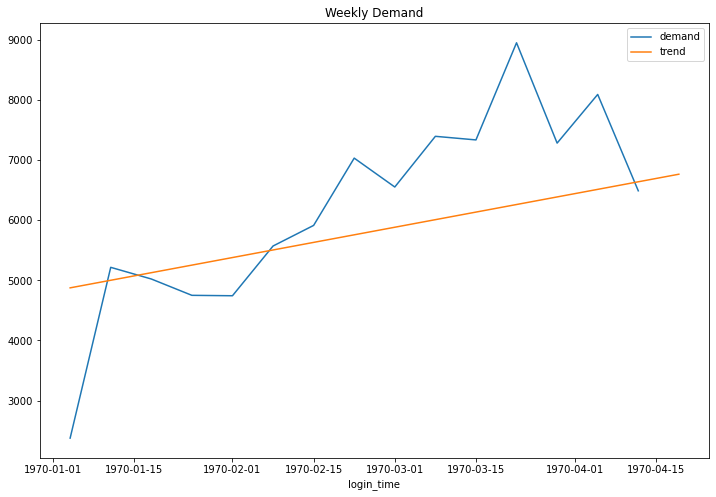

In [23]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_weekly[0:-1])
sns.lineplot(x=df_weekly.index, y=line_y, label='trend')
plt.title('Weekly Demand');

This trendline is much more meaningful. It still shows a slow increase in demand for Ultimate Technogies. At the weekly level, there is not much evidence of a pattern other than the upward trend of about 120 logins per week.

**CAUTION:** The trendline is **NOT** rigorous! It is a basic estimation.

### Aggregate Daily

In [24]:
df_daily = df.groupby([pd.Grouper(key='login_time', freq='1d')]).agg({'demand':'sum'})

In [25]:
X = range(len(df_daily.index))
y = df_daily['demand']
X = sm.add_constant(X)
daily_trendmodel = sm.OLS(y,X).fit()
line_y = daily_trendmodel.predict(X)

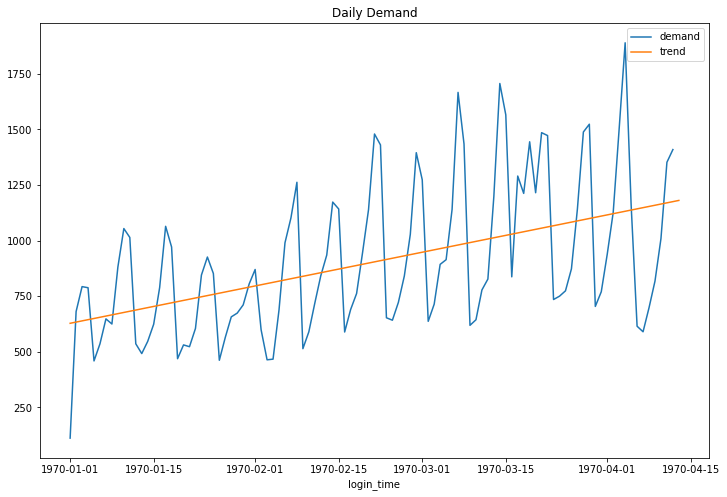

In [26]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_daily[0:-1])
sns.lineplot(x=df_daily.index, y=line_y, label='trend')
plt.title('Daily Demand');

There is a clear seasonality in the daily aggregation. Presumably, this pattern is people needing more rides either on the weekdays or weekends. The variance may also be increasing. Since this trendline looks pretty good and a large-enough sample size, I want to check the assumptions for the linear regression and see if this one can be rigorously trusted.

#### Residual Plots

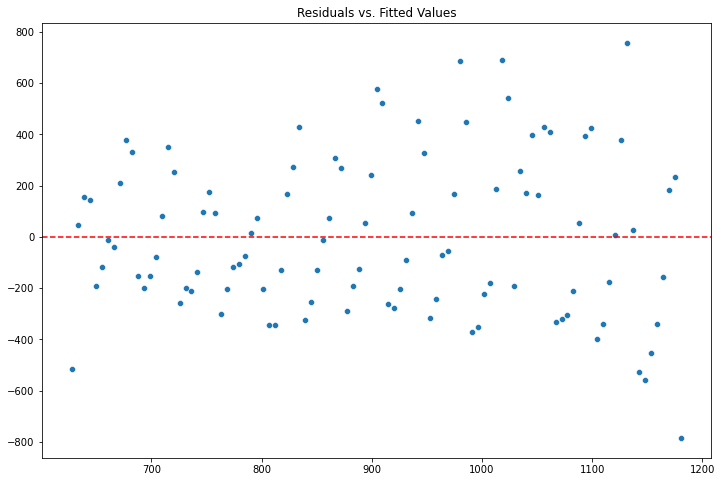

In [27]:
res = daily_trendmodel.resid
pred = line_y.copy()
plt.figure(figsize=(12,8))
plt.axhline(y=0, color='red', linestyle='dashed')
sns.scatterplot(x=pred, y=res)
plt.title('Residuals vs. Fitted Values');

These residuals actually look pretty good. They may grow a little bit as the predicted value gets higher, but not enough to make me worry about it. We should also check the residuals versus the predictor, or day.

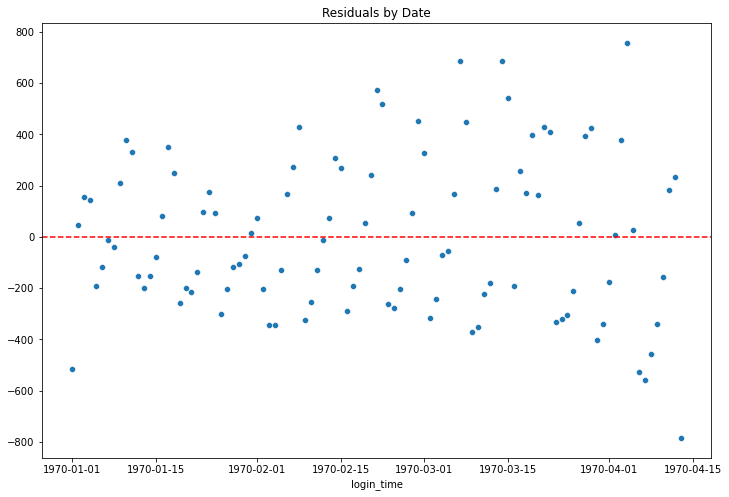

In [28]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=df_daily.index, y=res)
plt.axhline(0, color='red', linestyle='dashed')
plt.title('Residuals by Date');

The residuals look a *little* worse when plotted against the date. But not much. We just need to understand that the p-value we get in this regression may be a little lower than it should be. Let's view the regression summary now.

In [29]:
daily_trendmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     28.01
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           7.06e-07
Time:                        16:34:38   Log-Likelihood:                -735.57
No. Observations:                 103   AIC:                             1475.
Df Residuals:                     101   BIC:                             1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        628.1764     60.393     10.401      0.000     508.372     747.981
x1             5.4140      1.023      5.292      0.000       3.385       7.443
==============================================================================
Omnibus:                        2.046   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                2.005
Skew:                           0.271   Prob(JB):                        0.367
Kurtosis:                       2.585   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The predicted trend is to gain about 5 more logins every day.**

### SARIMA Analysis of Daily Aggregated Data

There is clearly a seasonal component in the daily aggregation. However, there might also be heteroscedasticity which would make a GARCH model more appropriate. Here, though, we are going to use a Seasonal Auto-Regressive Integrated Moving Average model (SARIMA) to learn some things about the seasonal patterns.

We can start by looking at plots of the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF).

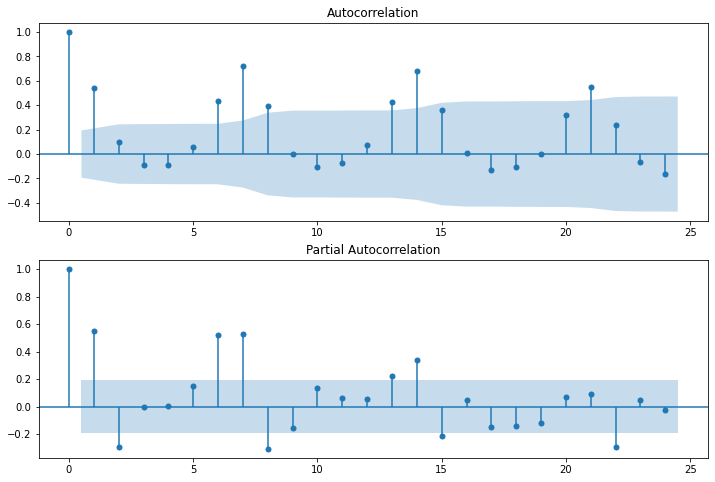

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'], lags=24, ax=ax2)
plt.show()

The ACF plot shows significant autocorrelation at multiples of 7 (and a day on either side of that lag). The PACF shows significant positive correlation at multiples of 7 as well, along with significant negative correlation at 3, 8, 15, and 23. Let's have a look at the ACF and PACF after first differencing.

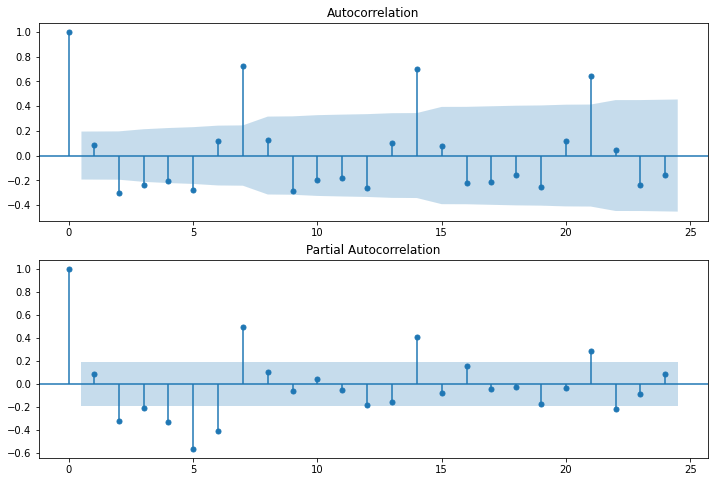

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'].diff().dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'].diff().dropna(), lags=24, ax=ax2)
plt.show()

Yeah, this ought to be easier to deal with. ACF shows weekly autocorrelation, and PACF shows weekly autocorrelation plus negative autocorrelation in lags 3-6. Let's also try the ACF and PACF of 7-differenced data.

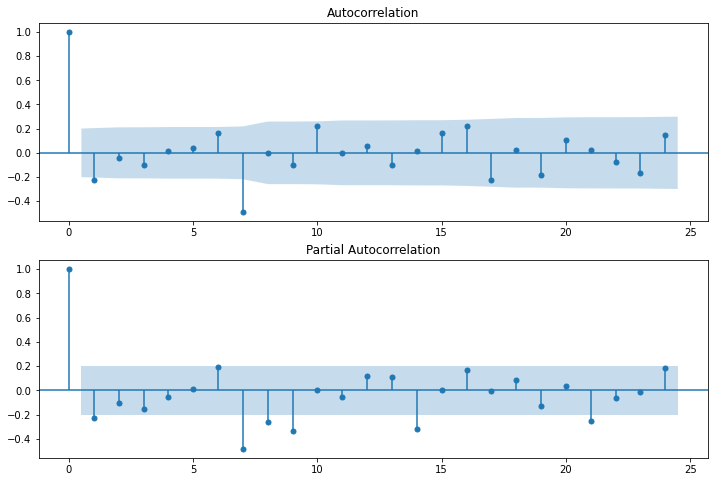

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_daily['demand'].diff().diff(7).dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_daily['demand'].diff().diff(7).dropna(), lags=24, ax=ax2)
plt.show()

On this differenced data, the ACF shows significant autocerrelation at lag 7, and the PACF shows autocorrelation at multiples of 7. They also both show a bit of significance at lag 1. We will now check the differenced series for stationarity, and if everything looks good we will fit an SARIMA(1,1,1)(1,1,1)7 model and draw some inference from that.

In [33]:
sm.tsa.stattools.adfuller(df_daily['demand'].diff().diff(7).dropna())

(-7.205263271588251,
 2.309080630259793e-10,
 8,
 86,
 {'1%': -3.5087828609430614,
  '5%': -2.895783561573195,
  '10%': -2.5850381719848565},
 1074.0380573581517)

The series is stationary (test statistic of -7.2 is more extreme than the 1% critical value of -3.5), so we can fit the model now.

In [34]:
model = sm.tsa.statespace.SARIMAX(df_daily['demand'], order=(1,1,1), seasonal_order=(1,1,1,7), trend='t')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            demand   No. Observations:                  103
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -609.028
Date:                           Wed, 31 Mar 2021   AIC                           1230.055
Time:                                   16:34:39   BIC                           1245.379
Sample:                               01-01-1970   HQIC                          1236.247
                                    - 04-13-1970                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0129      0.012     -1.054      0.292      -0.037       0.011
ar.L1          0.5907      0.143      4.132      0.000       0.311       0.871
ma.L1         -0.9989      2.028     -0.493      0.622      -4.973       2.976
ar.S.L7       -0.2409      0.189     -1.276      0.202      -0.611       0.129
ma.S.L7       -0.5939      0.144     -4.116      0.000      -0.877      -0.311
sigma2       1.95e+04   3.82e+04      0.511      0.610   -5.53e+04    9.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.37
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             0.12
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
np.sqrt(1.95e+04)

139.64240043768942

It turns out we didn't really need the seasonal auto-regressive coefficient (p=0.20) or the single-lag moving average coefficient (p=0.62). Also, the drift (trend) is not significant. There are also problems with the Jarque-Bera test, meaning the residuals are not normally distributed. This can also be seen in the high Kurtosis (normal distribution kurtosis = 3).

Most importantly, this more sophisticated model implies that there is no trend: The number of logins is **NOT** increasing over time!

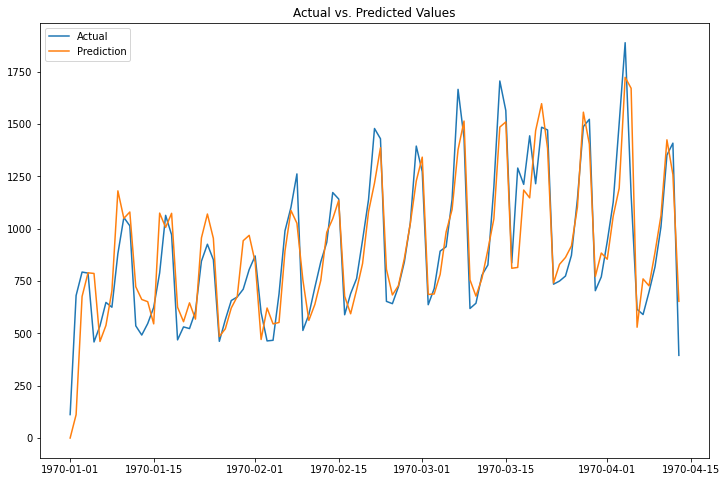

In [36]:
pred = results.predict()
plt.figure(figsize=(12,8))
plt.plot(df_daily, label='Actual')
plt.plot(pred, label='Prediction')
plt.title('Actual vs. Predicted Values')
plt.legend();

The model definitely seems to be capturing the behavior of the time series.

### Aggregate in 12-Hour periods

In [37]:
df_semidaily = df.groupby([pd.Grouper(key='login_time', freq='12h')]).agg({'demand':'sum'})

In [38]:
X = range(len(df_semidaily.index))
y = df_semidaily['demand']
X = sm.add_constant(X)
semidaily_trendmodel = sm.OLS(y,X).fit()
line_y = semidaily_trendmodel.predict(X)

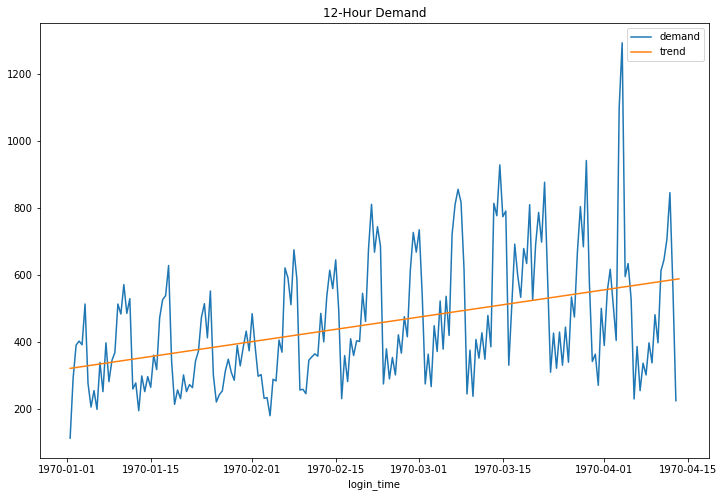

In [39]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_semidaily[0:-1])
sns.lineplot(x=df_semidaily.index, y=line_y, label='trend')
plt.title('12-Hour Demand');

The series is starting to show its variation more explicitly (longer times between measurements tends to denoise). While we can still see the 7-day seasonality, there is also a pattern in between the weekly spikes. The linear model predicts that the number of logins grows by about 1.3 every 12 hours; a slow but positive increase in the number of users. Let's look at creating a new SARIMA model to see what we can learn about the 12-hour patterns.

### 12-Hour SARIMA

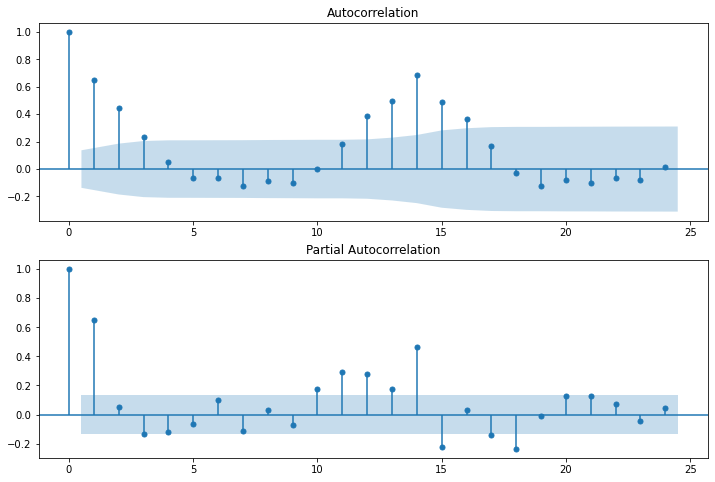

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_semidaily['demand'], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_semidaily['demand'], lags=24, ax=ax2)
plt.show()

Both the ACF and PACF plots show the 14-period (7-day) pattern we expected from before. They also show signs of non-stationarity. Let's take the first difference and 14-period difference and plot them again.

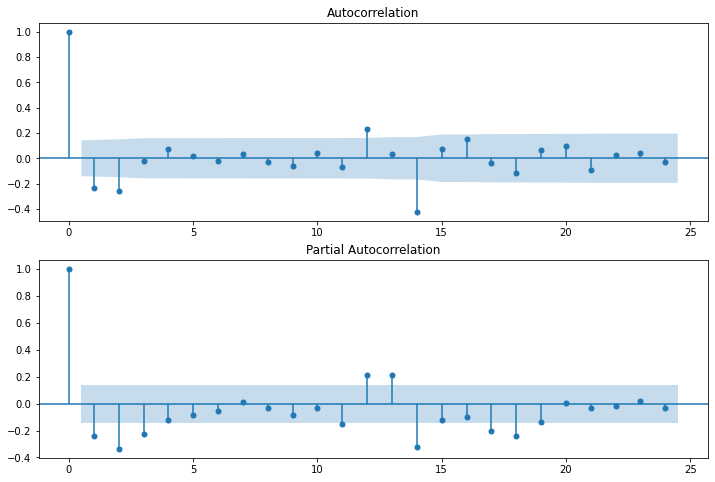

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_semidaily['demand'].diff().diff(14).dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_semidaily['demand'].diff().diff(14).dropna(), lags=24, ax=ax2)
plt.show()

There are still some significant lags. Let's build a SARIMA(3,1,0)(1,1,1)14 model and see what we can learn.

In [42]:
model = sm.tsa.statespace.SARIMAX(df_semidaily['demand'], order=(3,1,0), seasonal_order=(1,1,1,14), trend='t')
results = model.fit()


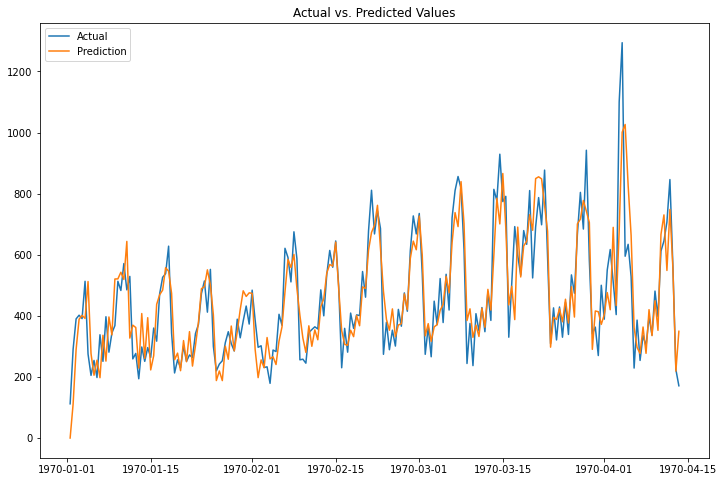

In [43]:
pred = results.predict()

plt.figure(figsize=(12,8))
plt.plot(df_semidaily, label='Actual')
plt.plot(pred, label='Prediction')
plt.title('Actual vs. Predicted Values')
plt.legend();

The model appears to be capturing the behavior of the time series quite well. Let's look for inference about the patterns.

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               demand   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(1, 1, [1], 14)   Log Likelihood               -1141.202
Date:                              Wed, 31 Mar 2021   AIC                           2296.404
Time:                                      16:34:41   BIC                           2319.133
Sample:                                  01-01-1970   HQIC                          2305.611
                                       - 04-13-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0148      0.020     -0.753      0.452      -0.053       0.024
ar.L1         -0.4979      0.049    -10.150      0.000      -0.594      -0.402
ar.L2         -0.3608      0.049     -7.425      0.000      -0.456      -0.266
ar.L3         -0.2804      0.057     -4.916      0.000      -0.392      -0.169
ar.S.L14      -0.1759      0.125     -1.403      0.161      -0.422       0.070
ma.S.L14      -0.6741      0.103     -6.557      0.000      -0.876      -0.473
sigma2      9049.8648    778.176     11.630      0.000    7524.667    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               122.18
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again, there is no evidence of a trend over time (we should have expected that). There is still the 7-day cycle. Importantly, at a 12-hour level, differenced demand is autoregressive for 3 periods, and the relationship is negative. For example, if the demand has decreased over the last three 12-hour periods, we can expect it to increase in the next 12 hours.

Take this with a grain of salt; the residuals are seriously non-normal.

### Intraweek Patterns

In this section, we are going to use the 12-hour aggregation to, split the data into weeks, and then look for intraweek patterns.

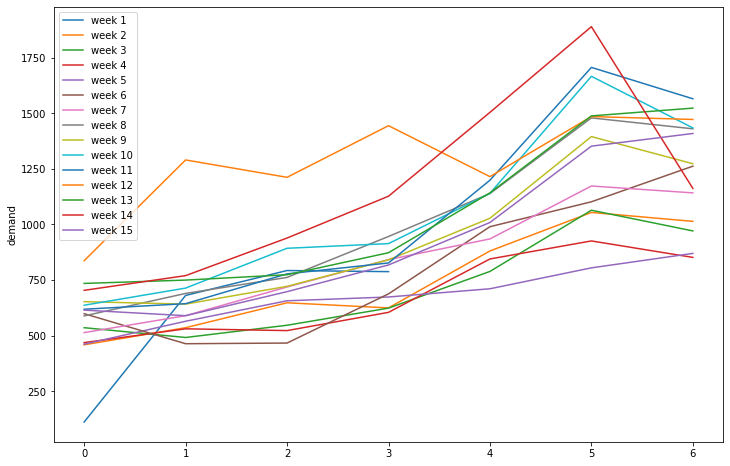

In [45]:
df_daily['week'] = df_daily.index.isocalendar().week
i = 1
plt.figure(figsize=(12,8))
for week in range(1, df_daily['week'].max()):
    temp = df_daily.loc[df_daily['week']==week, 'demand']
    sns.lineplot(x=range(len(temp)), y=temp, label=' '.join(['week', str(i)]))
    i += 1

We see a slow growth leading to a peak on the second-to-last day. Without knowing the actual date these observations were on, I cannot hypothesize the reason for this peak.

For this next plot, we are going to aggregate the date by hour, bin it into "morning", "afternoon", "evening", and "night", then group by the day of the week and looking at the average demand in each time_of_day over an average week.

In [46]:
df_hourly = df.groupby([pd.Grouper(key='login_time', freq='1h')]).agg({'demand':'sum'})
df_hourly['week'] = df_hourly.index.isocalendar().week
df_hourly['dayofweek'] = df_hourly.index.weekday
df_hourly['timeofday'] = 'night'
df_hourly.loc[df_hourly.index.hour > 6, 'timeofday'] = 'morning'
df_hourly.loc[df_hourly.index.hour > 12, 'timeofday'] = 'afternoon'
df_hourly.loc[df_hourly.index.hour > 18, 'timeofday'] = 'evening'

In [47]:
grouped_df = df_hourly.groupby(['dayofweek', 'timeofday']).mean()
grouped_df = grouped_df.reset_index()

In [48]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

In [49]:
grouped_df[grouped_df['timeofday'] == 'morning']

dayofweek timeofday     demand  week
2           0   morning  30.455556   9.0
6           1   morning  30.928571   8.5
10          2   morning  32.380952   8.5
14          3   morning  34.833333   8.5
18          4   morning  32.511111   8.0
22          5   morning  16.966667   8.0
26          6   morning  17.211111   8.0

In [50]:
pyo.init_notebook_mode()
fig = go.Figure(data = [
    go.Bar(name='morning', x=grouped_df.loc[grouped_df['timeofday'] == 'morning', "dayofweek"],
           y=grouped_df.loc[grouped_df['timeofday'] == 'morning', "demand"]),
    go.Bar(name='afternoon', x=grouped_df.loc[grouped_df['timeofday'] == 'afternoon', "dayofweek"],
           y=grouped_df.loc[grouped_df['timeofday'] == 'afternoon', "demand"]),
    go.Bar(name='evening', x=grouped_df.loc[grouped_df['timeofday'] == 'evening', "dayofweek"],
           y=grouped_df.loc[grouped_df['timeofday'] == 'evening', "demand"]),
    go.Bar(name='night', x=grouped_df.loc[grouped_df['timeofday'] == 'night', "dayofweek"],
           y=grouped_df.loc[grouped_df['timeofday'] == 'night', "demand"])])
fig.update_layout(barmode='stack')
fig.show()

Looking at the patterns in this chart, it looks like 0-4 are the weekdays, since there is greater demand in the morning; the weekends starts in the afternoon of day 4, when demand spikes, and the weekend is on days 5 and 6, when demand is high in the afternoon, evening, and night.

### Average Weekday Demand

In [51]:
daily_grouped_df = grouped_df[grouped_df['dayofweek'] <=4].groupby('timeofday').mean()
daily_grouped_df = daily_grouped_df.loc[["morning", 'afternoon', 'evening', 'night']]
fig = go.Figure(data=[
    go.Bar(x=daily_grouped_df['demand'], y=daily_grouped_df.index, text=round(daily_grouped_df['demand'],0), 
           textposition='auto', orientation='h')
])
fig.update_layout(barmode='stack')
fig.show()

### Weekend Demand

In [52]:
daily_grouped_df = grouped_df[grouped_df['dayofweek'] > 4].groupby('timeofday').mean()
daily_grouped_df = daily_grouped_df.loc[["morning", 'afternoon', 'evening', 'night']]
fig = go.Figure(data=[
    go.Bar(x=daily_grouped_df['demand'], y=daily_grouped_df.index, text=round(daily_grouped_df['demand'],0), 
           textposition='auto', orientation='h')
])
fig.update_layout(barmode='stack')
fig.show()

## Patterns in the Data

* There is a 7-day cycle
* The number of logins grows by between 0-5 per day
* There is a positive relationship between one day's change and the next day's; if demand increased/decreased yesterday, we expect it to increase/decrease today
* There is a negative relationship between a 12-hour period and the three preceding 12-hour periods; if demand increased/decreased for the last 36 hours, we expect it to decrease/increase over the next 12 hours
* Demand in the morning is highest on weekdays; demand in the afternoon grows thoughout the week, and is only greater than the morning demand on Saturday and Sunday; evening demand grows throughout the week to a spike on Friday, remains high on Saturday, and subsides on Sunday; late-night demand also grows throughout the week, but is relatively low on weekdays compared to weekends. 
* Total Demand is lower on weekdays that weekends; it grows throughout the week from a low of about 100 logins on Monday to over 200 logins on Saturday.
* The busiest time all week is late night on weekends, averaging 88 logins!

# Part 2

The issue in this part is that there are two neighboring cities separated by a toll-bridge, and we want to convince driver partners in those cities to work BOTH cities, rather than sticking to their side.

We've got too cities, Metropolis and Gotham, that are separated by a toll bridge. On weekends, both cities are busy pretty much all day. On weekdays, Metropolis is busy during the day, but Gotham is busy at night. Driver partners tend to either work in Gotham or Metropolis, but not both. We want to encourage them to cross over more often by reimbursing the tolls to cross the bridge. 

### How can we measure the effectiveness of the program?

Before we ask this question, we really should be more specific about what success looks like. Do we want more drivers to work both cities in the same day? Do we just care that they are working both cities intermittently? Do we want more drivers to cross the bridge when the other city is busy? Do we want more drivers willing to take passengers from one city to the other?

While all of these share the consideration that we want to be able to measure change in our metric, no two of them can be measured by the same metric, so we will consider them each separately.

My best guess is that we just want more people to cross over sometimes, even if they don't work both cities in the same day, so I will save that version of success for last. Now let's talk about the others.

* **We want more drivers to take passengers from one city to the other** - In this case, we can guess that drivers rarely accept assignments that they know cross the bridge. Thus, I propose that we measure the number of drivers that inter-city assignments are sent to before being accepted. With a large number of these measurements, we can construct the distribution (it should be approximately a Poisson distribution, but perhaps we can just use the empirical distribution) or the number of drivers such a trip is sent to before being accepted. This will give us a Cumulative Distribution Function (CDF), which is our real metric. For reference, this is how a CDF works:
    
    The probability of an inter-city trip being accepted by the first $N$ drivers to whom it is assigned is $P(n\le N)$, the value of the CDF at $N$.
    
    Now that we have a baseline CDF, we can make sure to let drivers know that tolls will be reimbursed, then allow them to operate as usual while we collect the same data again with the reimbursement program in place. I will explain why we can simply do this in the next paragraph. Once we have sufficient data (sample size will need to be determined according to the necessary precision), we will calculate the new empirical CDF, and test for stochastic dominance.
    
    A quick explanation of the outcome of the stochastic dominance test is: If the baseline CDF is lower than the experimental CDF at every number $N$, then the baseline CDF *stochastically dominates* the experimental CDF. Check the plot below for a visual that would indicate that the program is effective. Because stochastic dominance simply requires the baseline CDF to be greater than or equal to the experimental CDF at every point, all we need to do to test for stochastic dominance is plot the experimental CDFs like in the visual below. Thus, this is a nonparametric comparison with no underlying assumptions (except that the empirical CDF is representative of the true CDF, and so we can just collect data freely and not worry about whether it is i.i.d. or normally distributed or anything like that.
    
    There are three orders of stochastic dominance, but if the baseline CDF stochastically dominates the experimental CDF at any order, then we can conclude that the reimbursement program has raised the probability of a driver accepting an assignment that crosses the bridge. 

In [53]:
from scipy.special import factorial

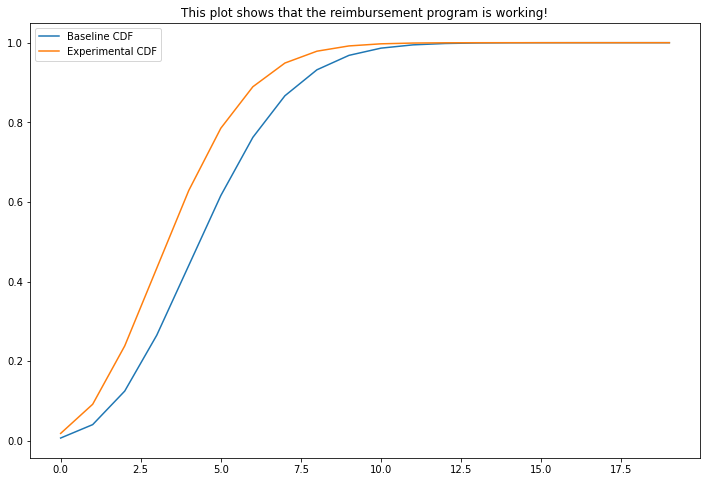

In [54]:
# Poisson CDF plot showing stochastic dominance goes here
t = np.arange(0,20,1)
pdf1 = np.exp(-5)*np.power(5,t) / factorial(t)
cdf1 = pdf1.cumsum()
pdf2 = np.exp(-4)*np.power(4,t) / factorial(t)
cdf2 = pdf2.cumsum()
plt.figure(figsize=(12,8))
plt.plot(t, cdf1, label='Baseline CDF')
plt.plot(t, cdf2, label='Experimental CDF')
plt.legend()
plt.title('This plot shows that the reimbursement program is working!');

* **We want drivers to work Metropolis in the daytime and Gotham at night, in the same day** - In this case, we need to track which drivers complete one assignment in Metropolis, and then later complete at least one assignment in Gotham. It would be good to track both the total number of driver partners that work in both cities in the same day and the proportion of driver partners that do so; we we need to know how many drivers, in raw numbers, are crossing over the bridge so we can plan for the expense of reimbursement; we also want to track the proportion, because the proportion of drivers who cross will be more indicative of the success of the program. For example, say that 10% of driver partners work both cities before the program; over the first month with reimbursements in place, the total number of drivers grows by 20%, but the number of drivers that work both cities grows by 10%...in this scenario, the proportion of drivers that work both cities actually declines to about 9%. 

    We should have access to the entire population of assignments, so we could just compute the population proportion before and after the program starts and compare them. However, this might be very computationally expensive, so instead we should just use simple random sampling to grab a representative sample of drivers (necessary sample size determined by necessary power and precision), then use a two-sample hypothesis test for difference in proportions. The major benefit of this method is that it is easy to understand; if the proportions are significantly different, then the reimbursement program is having and effect. But the method is not foolproof; we will be unable to separate the effect of the program from the effects of time or from the timing of the reimbursement program rollout. We can try to avoid these issues by comparing time at least a few months before the program with time at least a few months after the program starts, but that should only reduce the interfering effects of time and the program beginning itself. 
    
    For a more informative (but more technical) test, we could use intervention analysis. Here's how it works: We track the population proportion for several months (a large sample of weekdays) both before and after the program begins, then fit an appropriate ARIMA model to the data from before the rollout. We use that ARIMA model to predict the proportion for the time series after the program is in effect, and find the difference between the observed values and the predictions. Then, we can use those residuals to measure the effect of reimbursement on inter-city partners. There are several documented patterns that might be fit to the residuals, but it seems most likely that we should be estimating a gradually increasing effect that move the proportion to a new long-term mean. The new pattern model will look like this:
    
   $$z_t = \frac{\delta_0 \left( 1 - w_1^{t-T+1} \right)}{1 - w_1}I_t$$
   
   Wherein $I_t$ is 0 before the program begins and 1 afterward. We use the residuals to estimate $\delta_0$ and $w_1$. 
   
   We could also just fit an ARIMA model with $I_t$ as an exogenous variable to estimate a constant effect of the reimbursement program. The best choice of test to estimate the effect of them program is all about the tradeoff between technical sophistication and ease of explanation. The $z_t$ ARIMA method is the hardest to explain to a non-technical audience, but with appropriate visualizations and a good choice of words, any stakeholder ought to be able to understand it.

* **We want drivers to work in both cities, but don't care if it is on the same day** - This one is pretty similar to the previous version of success, but requires some small changes. Instead of using the proportion of drivers that work in both cities on any given day, we want to look at the proportion of drivers that complete enough assignments to justify reimbursing a bridge toll in each city. For the sake of this hypothetical, let's assume it is 3 assignments. For example, if a driver partner completed three assignments in Metropolis on Monday and then worked in Gotham over the rest of the week, that driver would count. Then, we would track the proportion of drivers that work in both cities over the course of several months before the reimbursement program and then a few months after the program. Then, we have the option of using the ARIMA method from the previous section or using a simpler method to estimate the effect of the reimbursement program.

To summarize, the best way to measure the effectiveness of the program depends on the actual goal of the project, which is not well defined in the question. However, three possible success scenarios and an appropriate metric for each has been outlined in the answer above. Since the company has access to the entire population of drivers and assignments, we could avoid the need for approximations by simply using all of the data, but that might be expensive and so we could also easily obtain an appropriately sized random sample of drivers/assignments as needed. We also have several options for tests that tell us the size of the effect the program is having; the best test will have the appropriate combination of sophistication and explainability.

# Part 3

In this part, we want to build a model that predicts customer retention, but the ultimate goal is to find a way to increase customer retention. This goal reduces our options for the structure of the model. The outcome is binary, either retained or not. The two classification models that immediately come to mind are Logistic Regression and Random Forest. Logistic Regression has many nice statistical properties that allow rigorous interpretation, while Random Forests are very intuitive, interpretable, and powerful. Both are quite easy to construct using the sci-kit learn package, so we will probably just make one of each. But that comes later. First, we need to prepare the data, explore it, and then we can make the models and examine results.

### Load Data

In [55]:
data = pd.read_json('ultimate_data_challenge.json')

In [56]:
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

### Prepare the Data

Hmmm...I want to know when the first `signup_date` and the last `last_trip_date` are, to get a feel for the section of time covered by the data.

In [57]:
## first signup_date
data.sort_values('signup_date', ascending=True).head(1)

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
4674  Astapor                       2  2014-01-01                   NaN   

      avg_surge last_trip_date   phone  surge_pct  ultimate_black_user  \
4674        1.0     2014-06-28  iPhone        0.0                False   

      weekday_pct  avg_dist  avg_rating_by_driver  
4674          0.0      4.03                   4.0

In [58]:
## last signup_date
data.sort_values('signup_date', ascending=True).tail(1)

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
30220  Winterfell                       0  2014-01-31                   5.0   

       avg_surge last_trip_date   phone  surge_pct  ultimate_black_user  \
30220        1.0     2014-04-06  iPhone        0.0                 True   

       weekday_pct  avg_dist  avg_rating_by_driver  
30220          0.0       3.5                   5.0

In [59]:
## last last_trip_date
data.sort_values('last_trip_date', ascending=False).head(1)

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
4486  Winterfell                       4  2014-01-25                   5.0   

      avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
4486        1.0     2014-07-01  Android        0.0                 True   

      weekday_pct  avg_dist  avg_rating_by_driver  
4486         25.0     11.94                   5.0

The data begins on January 1st, 2014, and runs until July 1st, 2014. All clients in this data signed up in January, so they have all been in the system for about 6 months. We are looking for a model that predicts whether a client will be retained after 6 months. A client counts as "active" if they've taken a trip in the last 30 days. The target variable, `retained` will be `True (1)` if the client has taken a trip between 2014-06-01 and 2014-07-01 and `False (0)` otherwise.

But first, I want to change the `signup_date` and `last_trip_date` columns into datetime data types.

In [60]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

All of the other data types look good. We can make the target column now.

In [61]:
# create target variable
data['retained'] = 1
data.loc[data['last_trip_date'] < '2014-06-01', 'retained'] = 0
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  
0         46.2      3.67                   5.0         1  
1         50.0      8.26                   5.0         0  
2        100.0      0.77                   5.0         0  
3         80.0      2.36                   4.9         1  
4         82.4      3.13                   4.9         0

Let's also change the `phone` and `ultimate_black_user` columns to ones and zeros (binary One-Hot Encoding);

* **phone** - `1` if the client has an iPhone, `0` for Android
* **ultimate_black_user** - `1` if the client is an ultimate black user, `0` otherwise

In [62]:
data['phone'] = (data['phone'] == 'iPhone')*1
data['ultimate_black_user'] = data['ultimate_black_user'] * 1
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date  phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17      1       15.4                    1   
1       1.00     2014-05-05      0        0.0                    0   
2       1.00     2014-01-07      1        0.0                    0   
3       1.14     2014-06-29      1       20.0                    1   
4       1.19     2014-03-15      0       11.8                    0   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  
0         46.2      3.67                   5.0         1  
1         50.0      8.26                   5.0         0  
2        100.0      0.77                   5.0         0  
3         80.0      2.36                   4.9         1  
4         82.4      3.13                   4.9         0

In [95]:
### OneHotEncode city
for col in data['city'].unique():
    data[col] = (data['city'] == col)*1

In [97]:
data.drop('city', axis=1, inplace=True)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   phone                   50000 non-null  int64         
 6   surge_pct               50000 non-null  float64       
 7   ultimate_black_user     50000 non-null  int64         
 8   weekday_pct             50000 non-null  float64       
 9   avg_dist                50000 non-null  float64       
 10  avg_rating_by_driver    49799 non-null  float64       
 11  retained                50000 non-null  int64         
 12  King's Landing          50000 non-null  int64 

There are quite a few `avg_rating_of_driver` missing. Since this seems likely to be an important feature, my first instinct is to drop the rows with missing values. There will still be plenty of observations left. But just in case I decide to fix the problem another way, I will not overwrite the DataFrame.

In [99]:
data_nona = data.dropna()
data_nona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  41744 non-null  int64         
 1   signup_date             41744 non-null  datetime64[ns]
 2   avg_rating_of_driver    41744 non-null  float64       
 3   avg_surge               41744 non-null  float64       
 4   last_trip_date          41744 non-null  datetime64[ns]
 5   phone                   41744 non-null  int64         
 6   surge_pct               41744 non-null  float64       
 7   ultimate_black_user     41744 non-null  int64         
 8   weekday_pct             41744 non-null  float64       
 9   avg_dist                41744 non-null  float64       
 10  avg_rating_by_driver    41744 non-null  float64       
 11  retained                41744 non-null  int64         
 12  King's Landing          41744 non-null  int64 

What proportion of the observed clients were retained? If the data is heavily unbalanced, we may need to take action to correct it before continuing.

In [100]:
data_nona['retained'].value_counts() / data_nona['retained'].value_counts().sum()

0    0.588971
1    0.411029
Name: retained, dtype: float64

About 60/40 unretained/retained; a nicely balanced target. Let's proceed to light exploration.

### Exploratory Data Analysis

Let's start the exploration with a pairplot of all 12 variables (including the target).

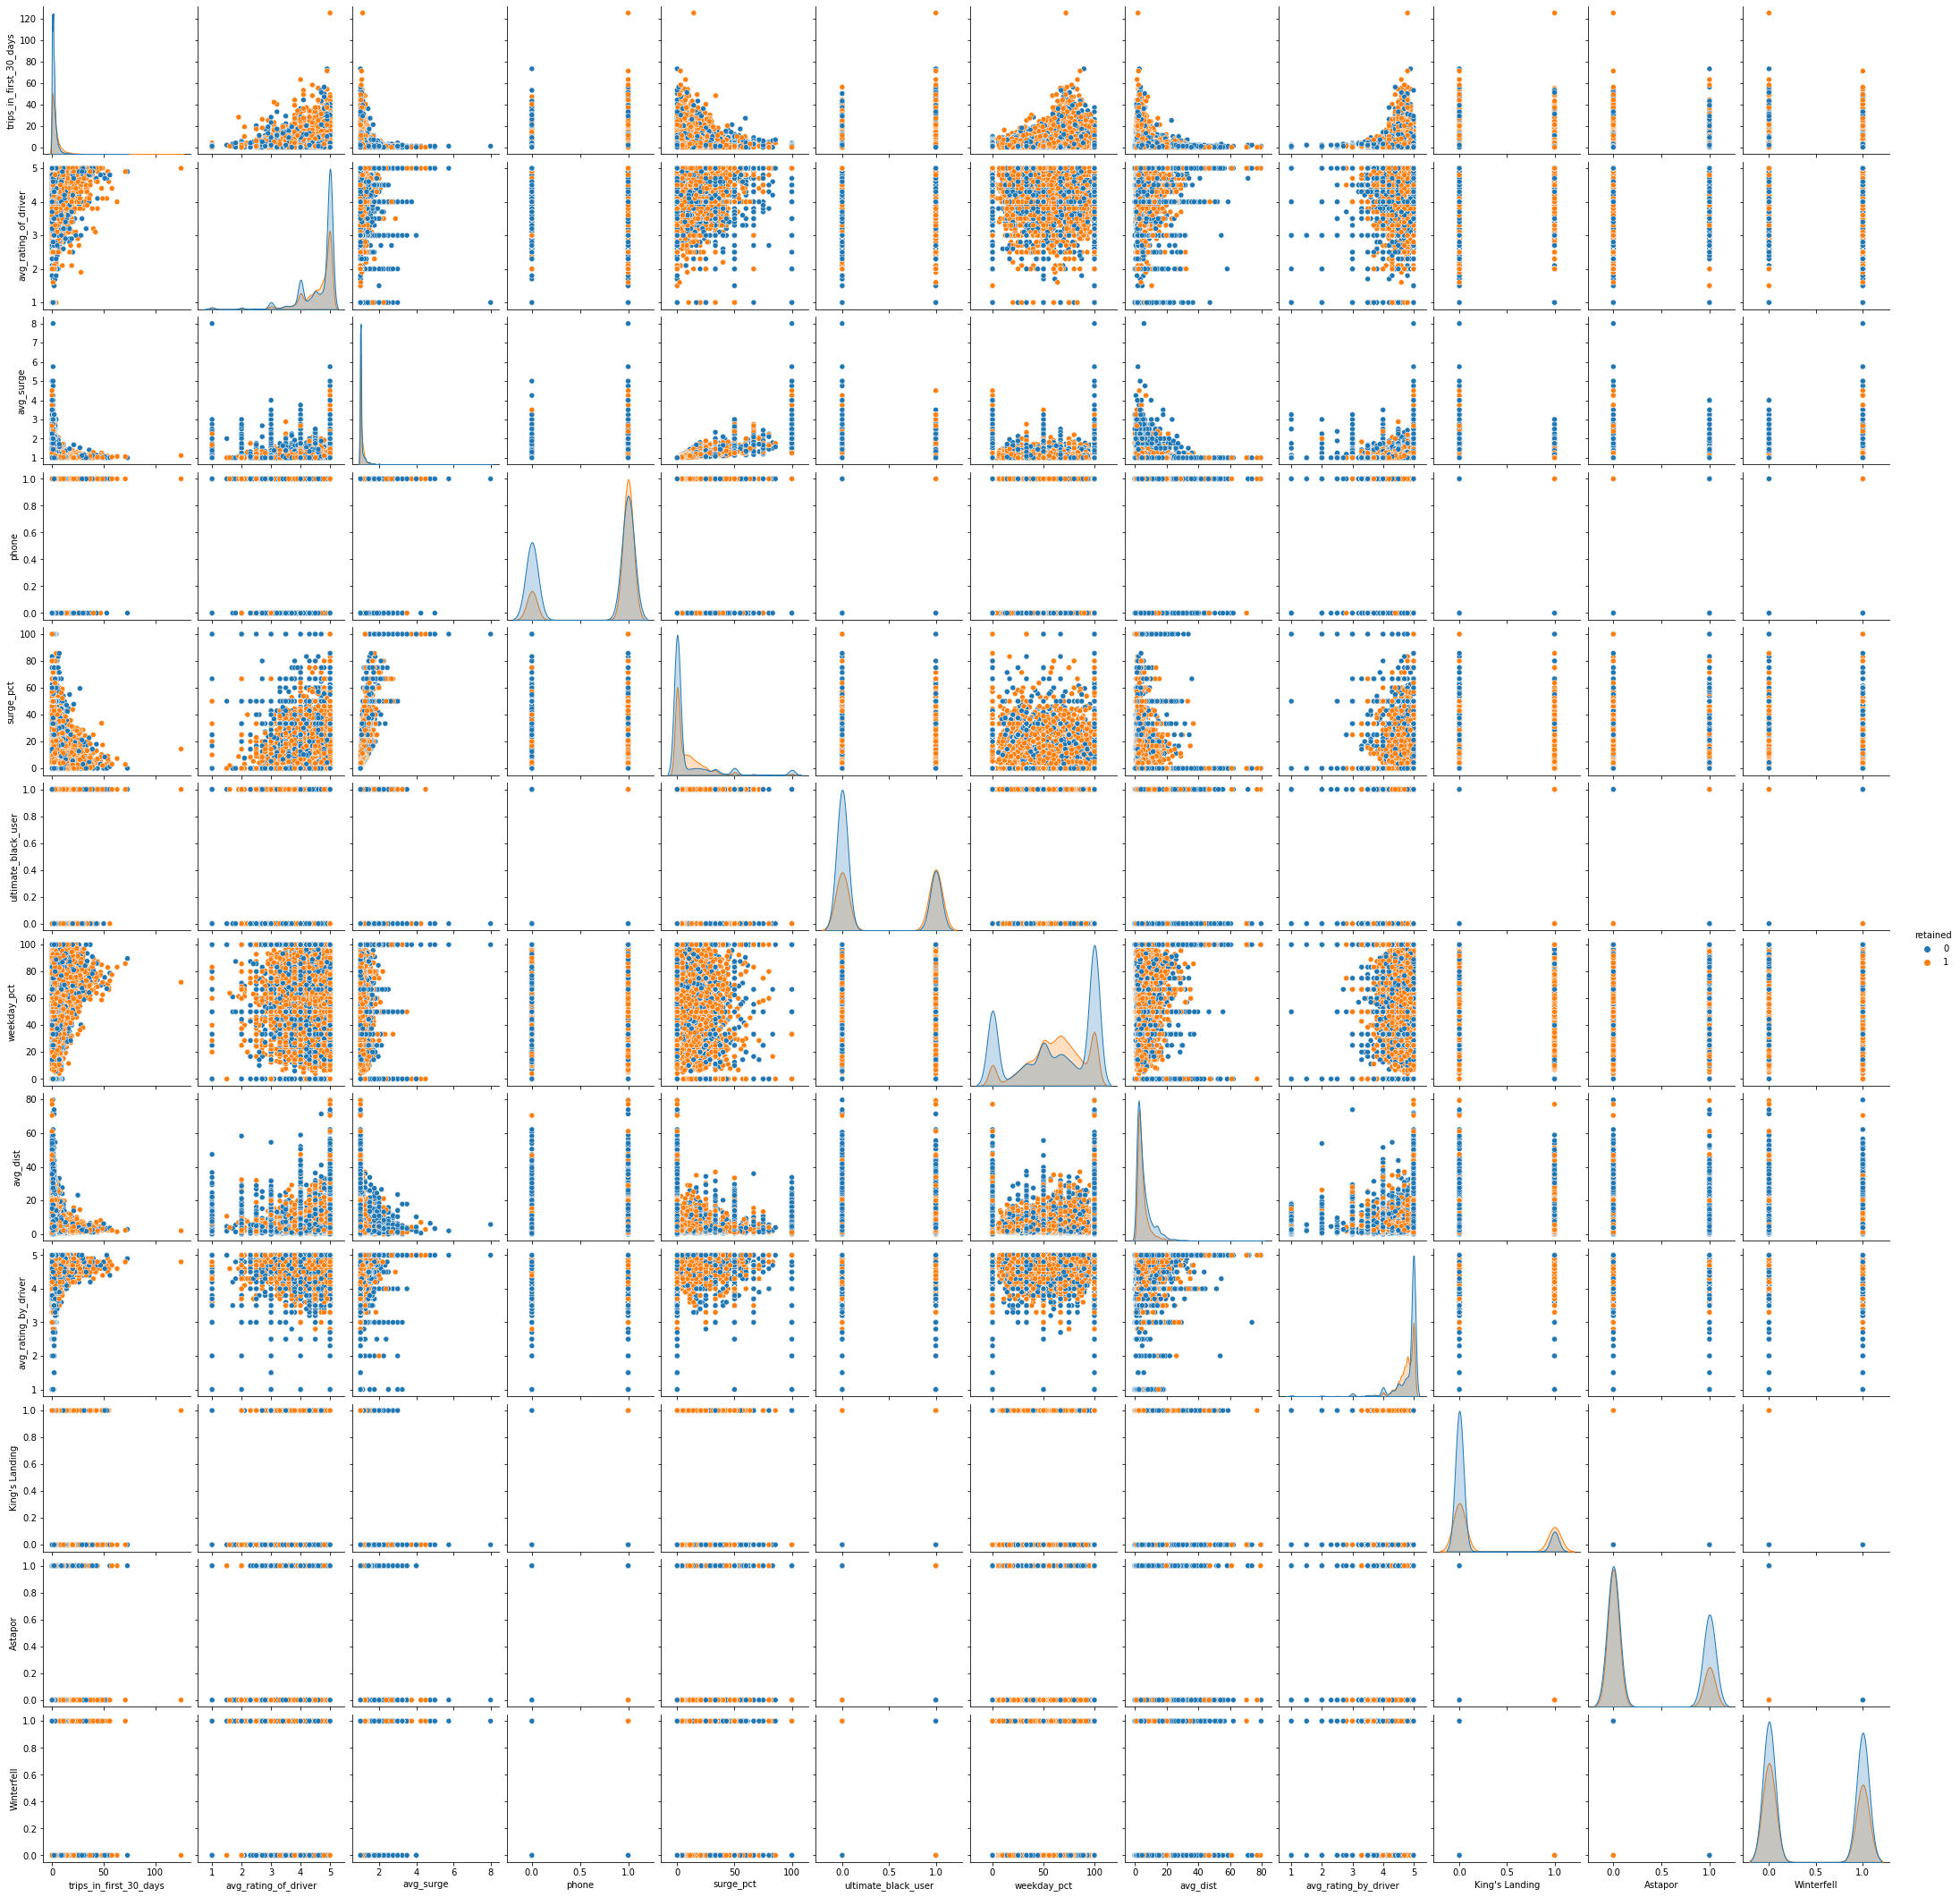

In [102]:
sns.pairplot(data_nona, hue='retained');

There isn't much that is informative in these scatterplots, and the distribution plots show significant overlap between retained and non-retained clients regardless of any feature. There is no one feature that can really explain retention. We will need to look at interactions between features for more insight.

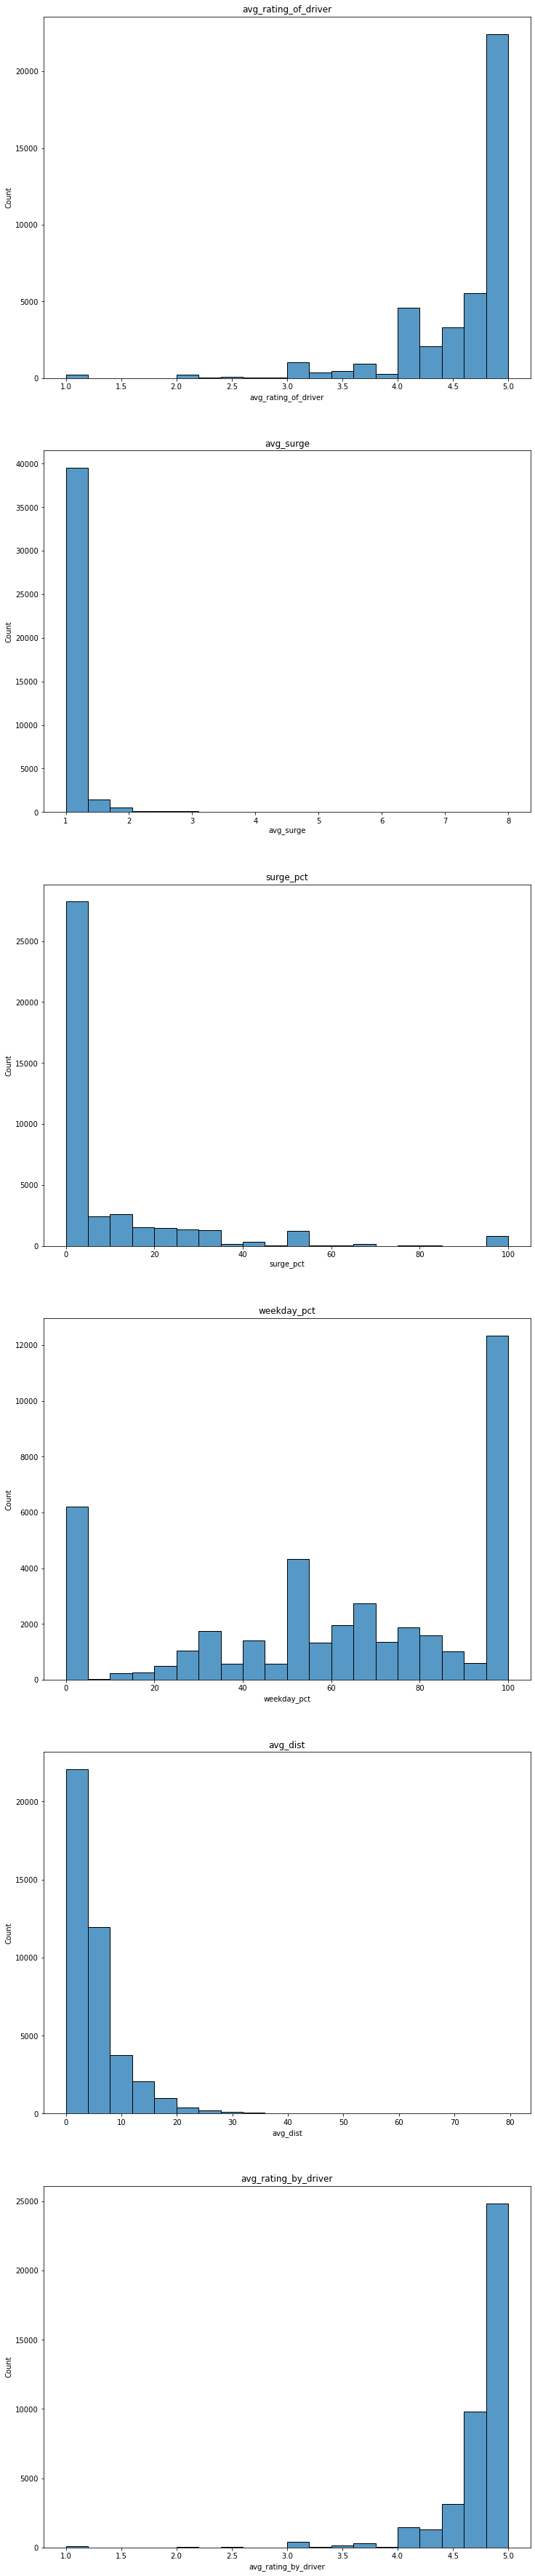

In [67]:
data_nona_numeric = data_nona.loc[:,data_nona.dtypes == 'float64']
plt.figure(figsize=(12,64))
i = 1
for col in data_nona_numeric.columns:
    plt.subplot(len(data_nona_numeric.columns), 1, i)
    sns.histplot(data_nona_numeric[col], bins=20)
    plt.title(col)
    i += 1

All of the numeric features have very skewed features. While Random Forests are nonparametric, other model types expect scaled data. Since these features have explicit maximums, we will scale them all between 0 and 1.

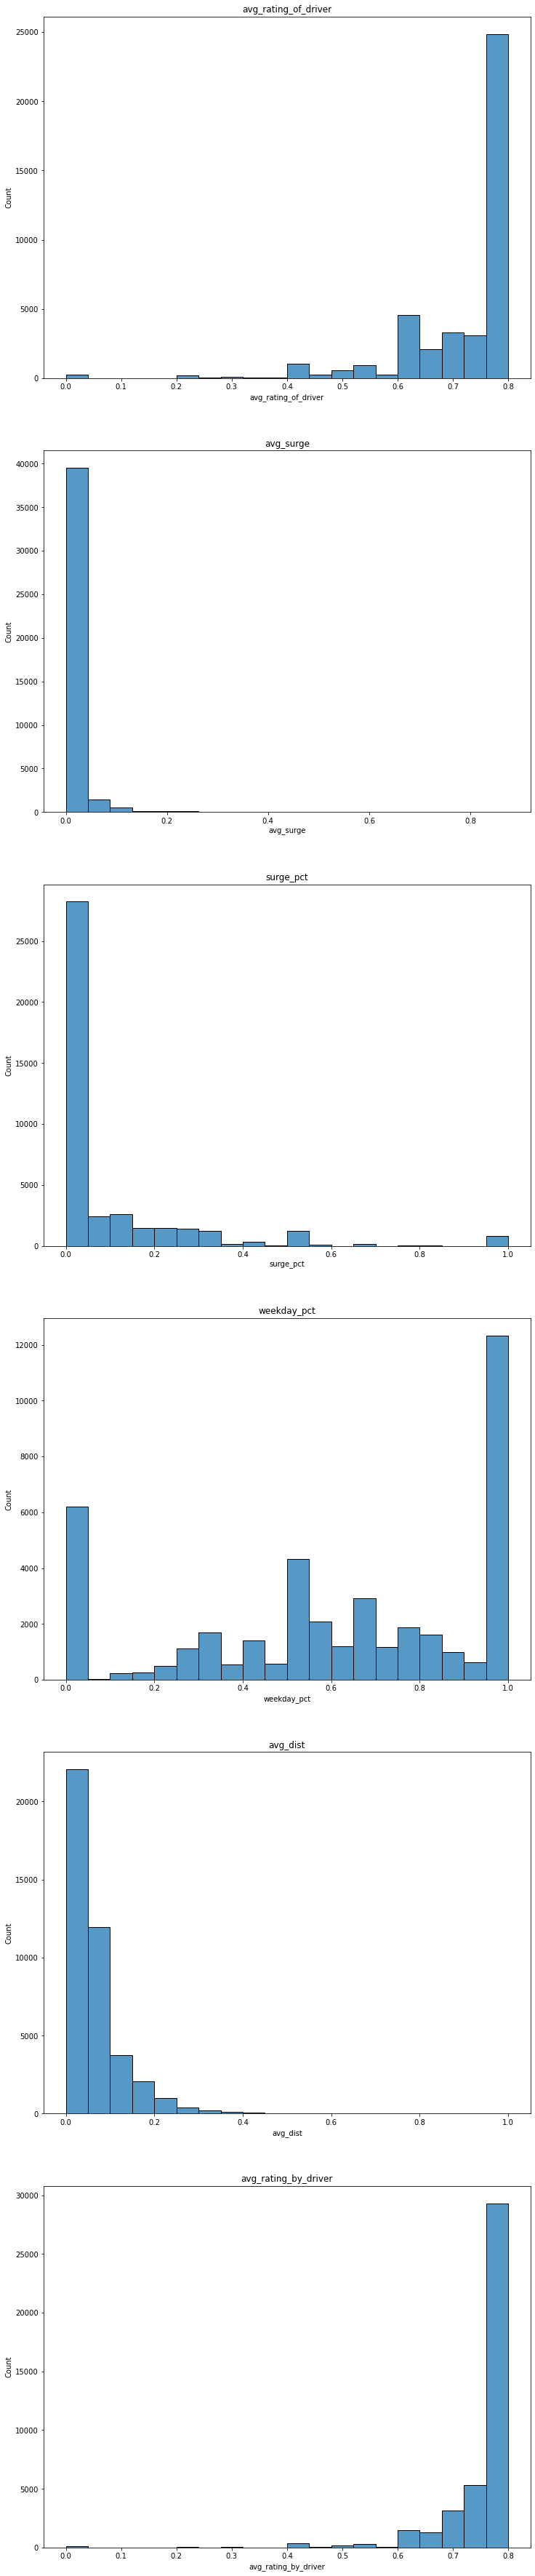

In [68]:
numeric_scaled = (data_nona_numeric - data_nona_numeric.min()) / data_nona_numeric.max()
plt.figure(figsize=(12,64))
i = 1
for col in numeric_scaled.columns:
    plt.subplot(len(numeric_scaled.columns), 1, i)
    sns.histplot(numeric_scaled[col], bins=20)
    plt.title(col)
    i += 1

In [103]:
non_numeric_features = data_nona.loc[:, data_nona.dtypes != 'float64'].copy()
non_numeric_features.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
non_numeric_features.head()

trips_in_first_30_days  phone  ultimate_black_user  retained  \
0                       4      1                    1         1   
1                       0      0                    0         0   
2                       3      1                    0         0   
3                       9      1                    1         1   
4                      14      0                    0         0   

   King's Landing  Astapor  Winterfell  
0               1        0           0  
1               0        1           0  
2               0        1           0  
3               1        0           0  
4               0        0           1

In [104]:
features = numeric_scaled.merge(non_numeric_features, left_index=True, right_index=True)
features.head()

avg_rating_of_driver  avg_surge  surge_pct  weekday_pct  avg_dist  \
0                  0.74    0.01250      0.154        0.462  0.046053   
1                  0.80    0.00000      0.000        0.500  0.103652   
2                  0.66    0.00000      0.000        1.000  0.009662   
3                  0.72    0.01750      0.200        0.800  0.029615   
4                  0.68    0.02375      0.118        0.824  0.039277   

   avg_rating_by_driver  trips_in_first_30_days  phone  ultimate_black_user  \
0                  0.80                       4      1                    1   
1                  0.80                       0      0                    0   
2                  0.80                       3      1                    0   
3                  0.78                       9      1                    1   
4                  0.78                      14      0                    0   

   retained  King's Landing  Astapor  Winterfell  
0         1               1        0           0  
1         0               0        1           0  
2         0               0        1           0  
3         1               1        0           0  
4         0               0        0           1

Now that all of the features are in good shape for modelling, let's check the correlation between them. Let's actually make another pairplot first, then check a correlation heatmap.

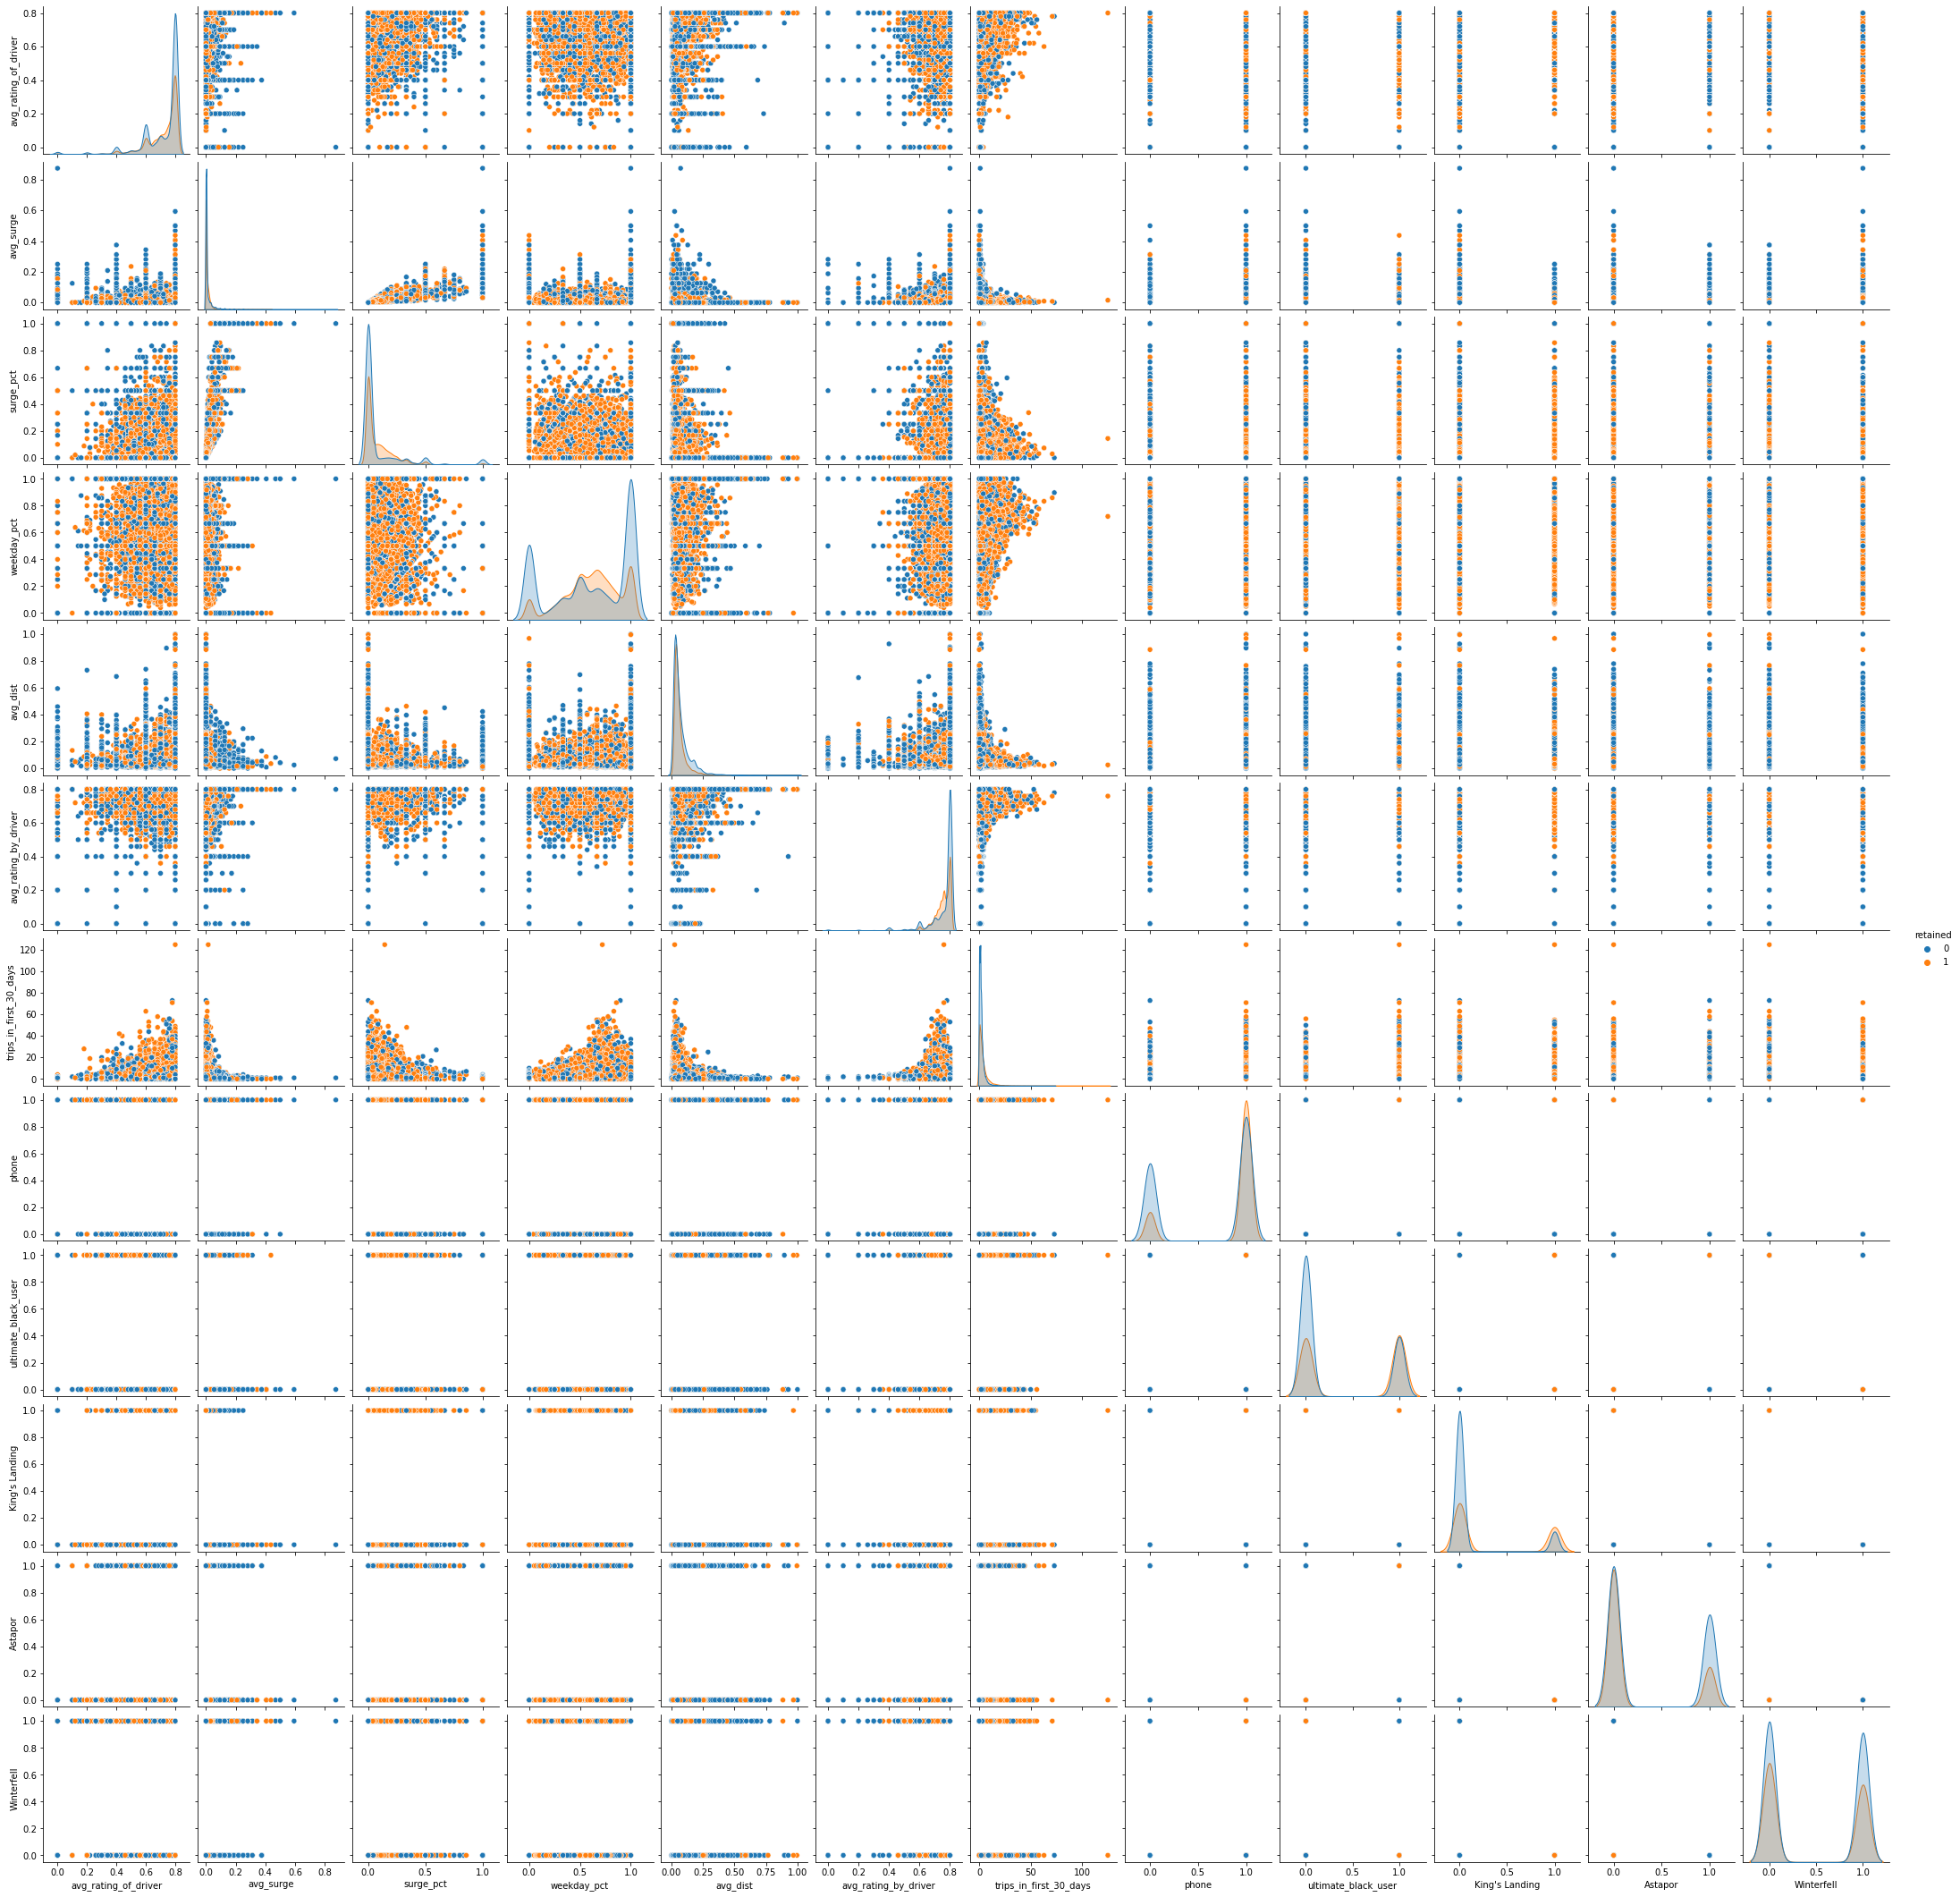

In [105]:
sns.pairplot(features, hue='retained');

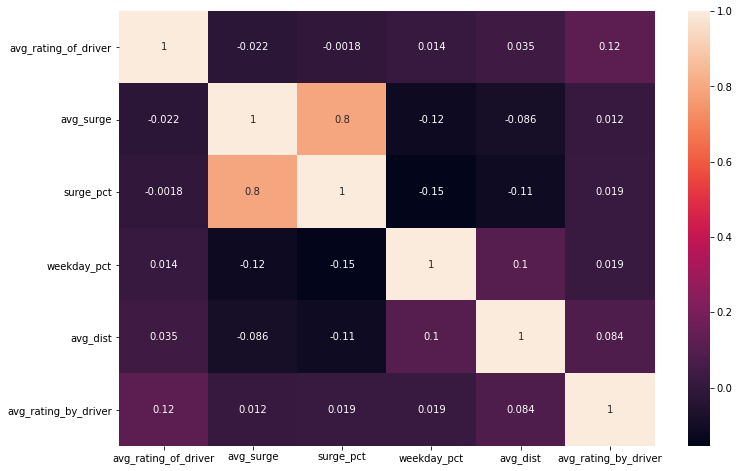

In [75]:
cormat = numeric_scaled.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cormat, annot=True);

The only correlation to worry about is that between `avg_surge` and `surge_pct`. Let's plot just those two features against one another.

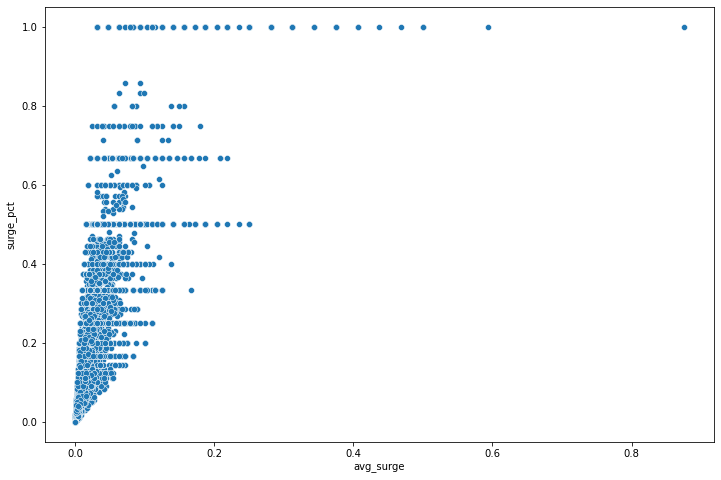

In [77]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='avg_surge', y='surge_pct', data=features);

`avg_surge` is the average surge multiplier across all of the client's trips. `surge_pct` is the percentage of the client's trips for which the surge multiplier was greater than 1. So it makes sense for these two to be correlated. For now, I am going to leave them both in. I also do not at this time think we need to engineer any new features. We will not create a Logistic Regression model from which we can gain more insight.

First, though, let's split the data into draining and test sets.

### Split Data into Training and Test sets

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
X = np.array(features.drop('retained', axis=1))
y = np.array(features['retained'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [108]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33395, 12) (33395,)
(8349, 12) (8349,)


### Fit and Evaluate Logistic Regression Model

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [110]:
log_mod = LogisticRegression()
log_fit = log_mod.fit(X_train, y_train)

/Users/johnrizcallah/opt/anaconda3/envs/ultimate_challenge/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [112]:
pred = log_fit.predict(X_test)
accuracy_score(y_test, pred)

0.7119415498862139

AttributeError: 'LogisticRegression' object has no attribute 'summary'